In [1]:
import os
import keras
import numpy as np
import pandas as pd
import io
import bson
from subprocess import check_output
import multiprocessing as mp 

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_DIR = "/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/"

In [15]:
%pylab inline
from skimage.data import imread

Populating the interactive namespace from numpy and matplotlib


# Pre-processing bson input
[jump](#HERE)
* First we map category_id to an integer for one-hot
* Second, we pre-process the bson file so we can randomly access each image. We store the offset and length of product item info into a .csv file

In [13]:
from src.make_lookup_tables import *

In [4]:
# making category_id -> category_idx lookup table
# make_categories_df(os.path.join(DATA_DIR, "category_names.csv"))

categories_df = pd.read_csv(os.path.join(DATA_DIR, "categories.csv"), index_col=0)
categories_df.head()

,category_level1,category_level2,category_level3,category_idx,category_level1_EN,category_level2_EN
category_id,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,subscription / services,prepaid card
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,urban development - roads,urban development
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,urban development - roads,urban development
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,urban development - roads,urban development
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,urban development - roads,signage


In [210]:
train_offsets_df = make_offsets_df()

100%|██████████| 7069896/7069896 [04:27<00:00, 26459.74it/s]


Offset table saved as:  /home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/train_offsets.csv


In [5]:
train_offsets_df = pd.read_csv("/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/train_offsets.csv",
                               index_col=0)

/home/femianjc/anaconda2/envs/femiani/lib/python2.7/site-packages/numpy/lib/arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [234]:
train_val_split(train_offsets_df, split_percentage=.2)

7069896it [00:09, 723493.05it/s]
100%|██████████| 7069896/7069896 [07:14<00:00, 16270.68it/s]


Training images saved as:  /home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/train_images.csv
Validation images saved as:  /home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/val_images.csv


In [7]:
train_images_df = pd.read_csv(os.path.join(DATA_DIR, "train_images.csv"))

In [8]:
val_images_df = pd.read_csv(os.path.join(DATA_DIR, "val_images.csv"))

In [9]:
print "Number of training images:", len(train_images_df)
print "Number of validation images:", len(val_images_df)
print "Total images:", len(train_images_df) + len(val_images_df)
print "Percentage of training images is: ", float(len(train_images_df))/(len(train_images_df) + len(val_images_df))

Number of training images: 9901629
Number of validation images: 2469664
Total images: 12371293
Percentage of training images is:  0.800371392061


# Dataset

Now we are interested in the distribution of target classes. This is an extreme classification problem, with 5270 target classes, comparing with ImageNet, having only 1000 object categories. Also, lots of the target classes are under-represented.

In [11]:
print "Number of categories in training data: ", len(train_images_df["category_idx"].unique())
print "Number of categories in validation data: ", len(val_images_df["category_idx"].unique())

Number of categories in training data:  5270
Number of categories in validation data:  5270


In [13]:
num_samples_per_category = train_images_df.category_idx.value_counts(normalize=False)
bins = np.arange(0,2000,20)

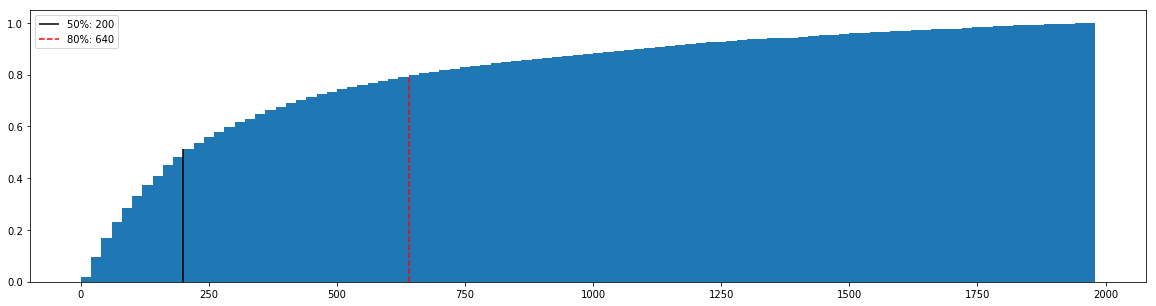

In [16]:
figsize(20, 5)
out = hist(array(num_samples_per_category), bins=bins, cumulative=True, density=True);
# plot 50% 
i1 = abs(out[0]-0.5).argmin()
vlines(out[1][i1], ymin=0, ymax=out[0][i1], label='50%: '+ str(out[1][i1]) )
# plot 80%
i2 = abs(out[0]-0.8).argmin()
vlines(out[1][i2], ymin=0, ymax=out[0][i2], linestyles="dashed", colors='r', label='80%: '+ str(out[1][i2]) )
legend()

Around 50% of the classes have less than 200 images. Only 20% of the classes has more than 640 images representing them. Which means for each specific class, the number of samples is not sufficient. 

In [54]:
# category_idx == 619 images as sanity check
label = categories_df[categories_df.category_idx==619].iloc[:, [4,5,2]]
print "labels-lvl1: {}, lvl2: {}, lvl3: {}". format(label.category_level1_EN.values[0], 
                                              label.category_level2_EN.values[0], 
                                              translator.translate(label.category_level3.values[0]).text)

labels-lvl1: auto Moto, lvl2: tools, lvl3: SOCKETS - BITS


In [283]:
def plot_category(category_idx):
    label = categories_df[categories_df.category_idx==619].iloc[:, [4,5,2]]
#     print "labels-lvl1: {}, lvl2: {}, lvl3: {}". format(label.category_level1_EN.values[0],
#                                                         label.category_level2_EN.values[0],
#                                                         translator.translate(label.category_level3.values[0]).text)
    
    input1 = train_images_df[train_images_df.category_idx==category_idx]
    idx = np.random.randint(0, len(input1))
#     print "Number of total images: ", len(input1)
#     print idx
    r = input1.iloc[idx,:]
    input1_imgidx = r.img_idx
    input1_productid = r.product_id
#     print "ImageID: ", input1_productid
#     print "Imageidx: ", input1_imgidx
    
    record = train_offsets_df[train_offsets_df.index==input1_productid]
    offset = record.offset.values[0]
    length = record.length.values[0]

    with open("data/train.bson") as b:
        b.seek(offset)
        sample = b.read(length)
        item = bson.BSON(sample).decode()
        # pic = imread(io.BytesIO(item['imgs'][0]['picture']))
        pic = imread(io.BytesIO(item['imgs'][input1_imgidx]['picture']))
    return pic, (input1_productid, input1_imgidx)
    # imshow(pic)
    # print pic.shape

In [284]:
print "labels-lvl1: {}, lvl2: {}, lvl3: {}". format(label.category_level1_EN.values[0], 
                                              label.category_level2_EN.values[0], 
                                              translator.translate(label.category_level3.values[0]).text)

labels-lvl1: telephony - gps, lvl2: telephone accessory, lvl3: HANDS-FREE KIT - BLUETOOTH TELEPHONE CAR KIT


labels-lvl1: telephony - gps, lvl2: telephone accessory, lvl3: HANDS-FREE KIT - BLUETOOTH TELEPHONE CAR KIT


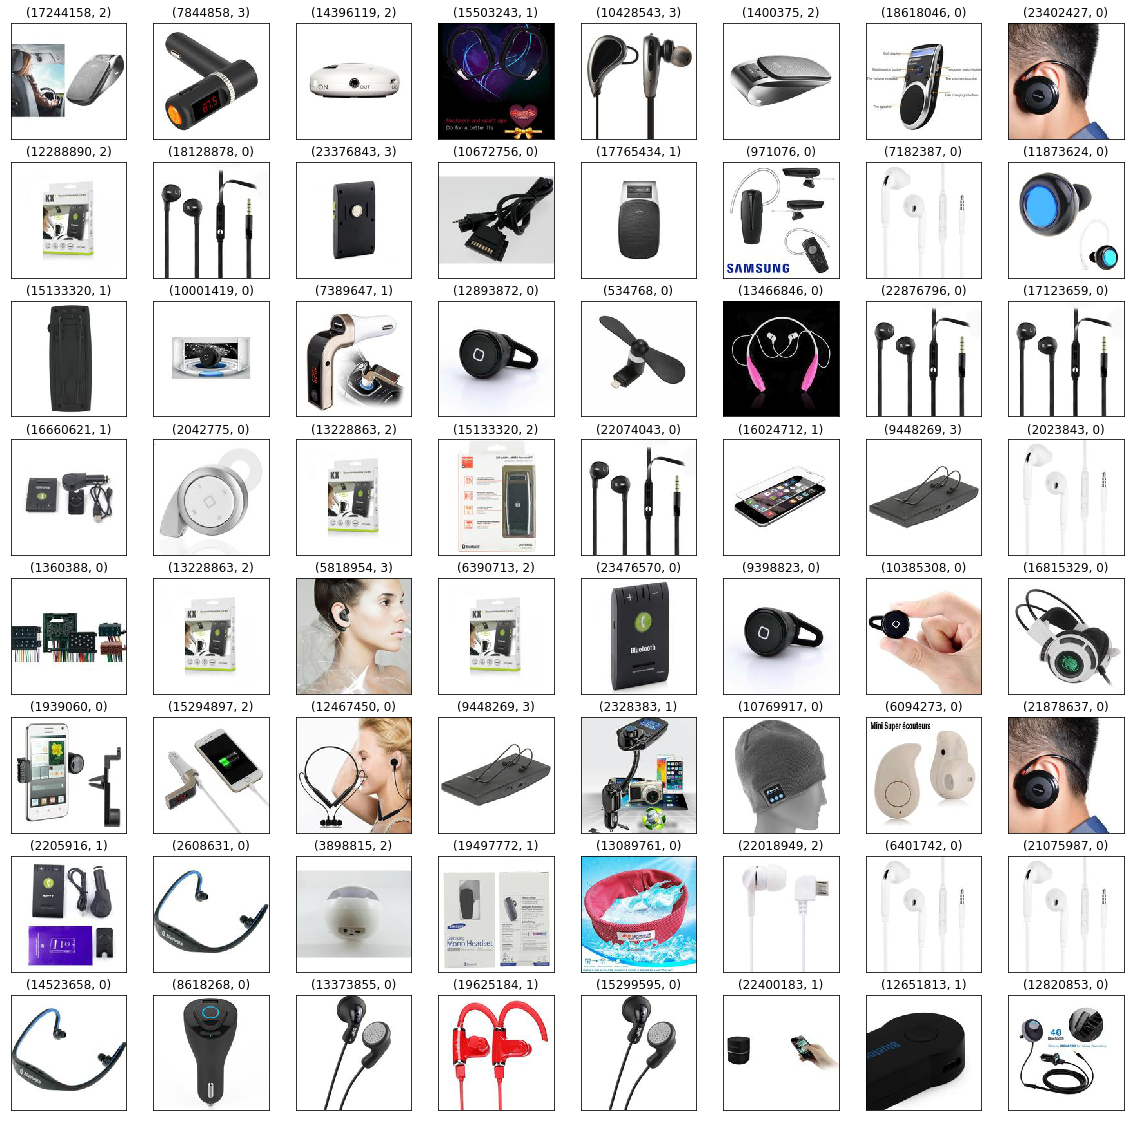

In [285]:
m = 8
n = 8
category_idx = 5070
fig, axes = subplots(m, n)
fig.set_size_inches(m* 2.5,n * 2.5)

for row in range(n):
    for col in range(m):
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        sca(axes[row, col])
        pic, info = plot_category(category_idx)
        title(info)
        imshow(pic)
        
label = categories_df[categories_df.category_idx==category_idx].iloc[:, [4,5,2]]
print "labels-lvl1: {}, lvl2: {}, lvl3: {}". format(label.category_level1_EN.values[0], 
                                              label.category_level2_EN.values[0], 
                                              translator.translate(label.category_level3.values[0]).text)

labels-lvl1: auto Moto, lvl2: tools, lvl3: SOCKETS - BITS
Number of total images:  1768
149
3
2319762
(180, 180, 3)


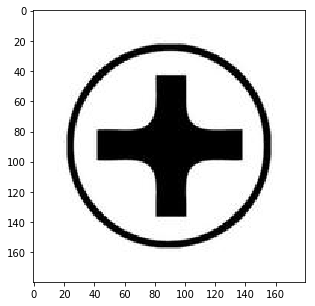

In [236]:
plot_category(619)

# Define Tensorflow computational graph

In [244]:
import tensorflow as tf

from tensorflow.python.framework.ops import convert_to_tensor
from tensorflow import data
from tensorflow.python.framework import dtypes

In [246]:
with tf.device("/cpu:0"):

    dataset = data.TextLineDataset("data/train_images.csv").skip(1)
    iterator = dataset.make_initializable_iterator()
    record_defaults = [[1], [1], [1]]
    
    product_id, category_idx, img_idx = tf.decode_csv(iterator.get_next(), record_defaults=record_defaults)
    lookup = tf.stack([product_id, img_idx])
    

In [247]:
sess = tf.InteractiveSession()

In [248]:
# Initialize an iterator over a dataset with 10 elements.
sess.run(iterator.initializer)
sess.run(features)

array([36254,   619,     0], dtype=int32)

In [341]:
counts = train_images_df.category_idx.value_counts()
(counts < 50).sum()/5200.

0.115

In [311]:
train_images_df[train_images_df.category_idx==5067]

,product_id,category_idx,img_idx
6242832,8,5067,0
6242833,64,5067,0
6242834,64,5067,1
6242835,64,5067,2
6242836,77,5067,0
6242837,98,5067,0
6242838,98,5067,1
6242839,98,5067,2
6242840,98,5067,3
6242841,122,5067,0
